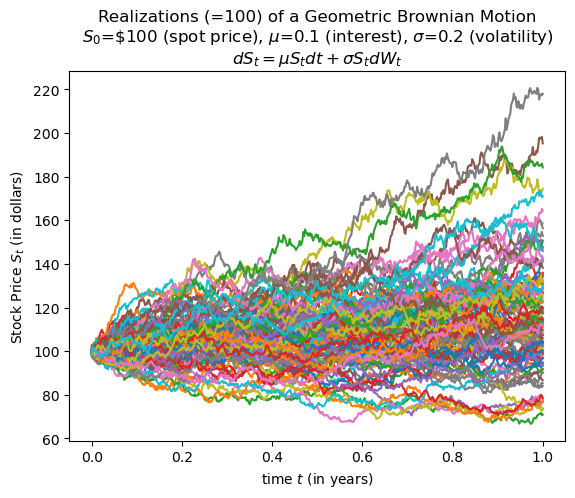

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mu = 0.10 # risk-free interest rate
sigma = 0.20 # volatility  
S0 = 100 # (initial) spot price
n = 500 # number of time series steps
T = 1 # time to maturity
m = 100 # number of simulations

dt = T/n
dlogSt = mu * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(m, n))
St =  S0 * np.exp(np.cumsum(dlogSt, axis=-1))
t = np.full(shape=(m, n), fill_value = np.linspace(0, T, n))

plt.plot(t.T, St.T)
plt.title(f"Realizations (={m}) of a Geometric Brownian Motion\n$S_0$=\\${S0} (spot price), $\\mu$={mu} (interest), $\\sigma$={sigma} (volatility)\n$dS_t = \\mu S_t dt + \\sigma S_t dW_t$")
plt.xlabel("time $t$ (in years)")   
plt.ylabel("Stock Price $S_t$ (in dollars)")
plt.show()

In [2]:
from scipy.stats import norm
from numba import njit
from math import fabs, erf, erfc, exp

@njit(cache=True, fastmath=True)
def cdf(d):
    if (np.isnan(d)):
        return np.nan
    x = d * 1.0/np.sqrt(2.)
    z = fabs(x)
    if (z < 1.0/np.sqrt(2.)):
        y = 0.5 + 0.5 * erf(x)
    else:
        y = 0.5 * erfc(z)
        if (x > 0):
            y = 1.0 - y
    return y


@njit(cache=True, fastmath=True)
def compute_prices(S0, K, mu, sigma, T):
    d1 = (np.log(S0 / K) + (mu + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # expectation of call and put prices
    call = S0 * cdf(d1) - (K * np.exp(-(mu * T)) * cdf(d2))
    put = (K * np.exp(-(mu * T)) * cdf(-d2)) - S0 * cdf(-d1) 
    return call, put

@njit(cache=True, fastmath=True)
def price_heatmap(buy=False):
    vols = np.linspace(sigma*0.9, sigma*1.1, 10)
    spots = np.linspace(S0*0.9, S0*1.1, 10)
    calls = np.zeros((len(vols), len(spots)))
    puts = np.zeros((len(vols), len(spots)))

    for i, vol in enumerate(vols):
        for j, spot in enumerate(spots):
            if buy:
                call, put = compute_prices(spot, K, mu, vol, T)
                call, put = call - buy, put - buy
                calls[i, j], puts[i, j] = call, put 
            else:
                calls[i, j], puts[i, j] = compute_prices(spot, K, mu, vol, T)
    return calls, puts

K = 100 # (exercise) strike price
compute_prices(S0, K, mu, sigma, T)

(13.2696765846609, 3.7534183882568417)

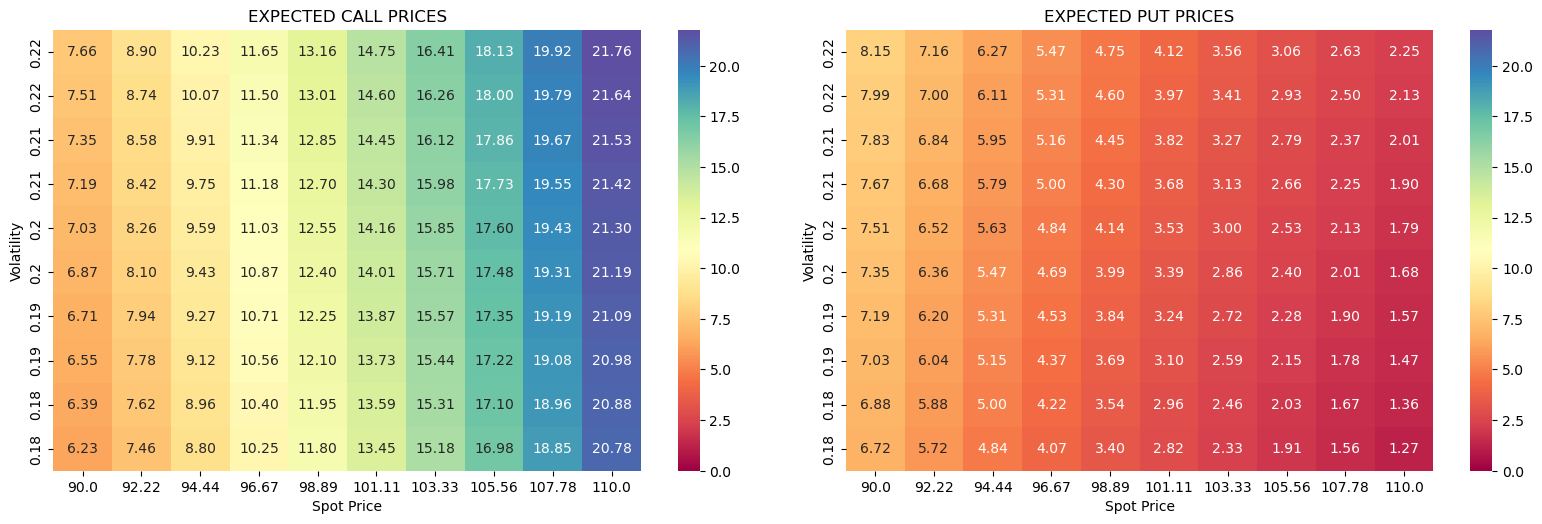

In [3]:
import seaborn as sns

calls, puts = price_heatmap()

vmax = max(calls.max(), puts.max())

fig, (ax_call, ax_put) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout()

vols = np.linspace(sigma*0.9, sigma*1.1, 10)
spots = np.linspace(S0*0.9, S0*1.1, 10)

for title, values, ax in [('CALL', calls, ax_call), ('PUT', puts, ax_put)]:
    sns.heatmap(values, cmap="Spectral", ax=ax, xticklabels=np.round(spots, 2), yticklabels=np.round(vols, 2), fmt=".2f", annot=True, vmin=0, vmax=vmax)
    ax.set_title(f'EXPECTED {title} PRICES')
    ax.set_xlabel('Spot Price')
    ax.set_ylabel('Volatility')
    ax.invert_yaxis()
plt.show()

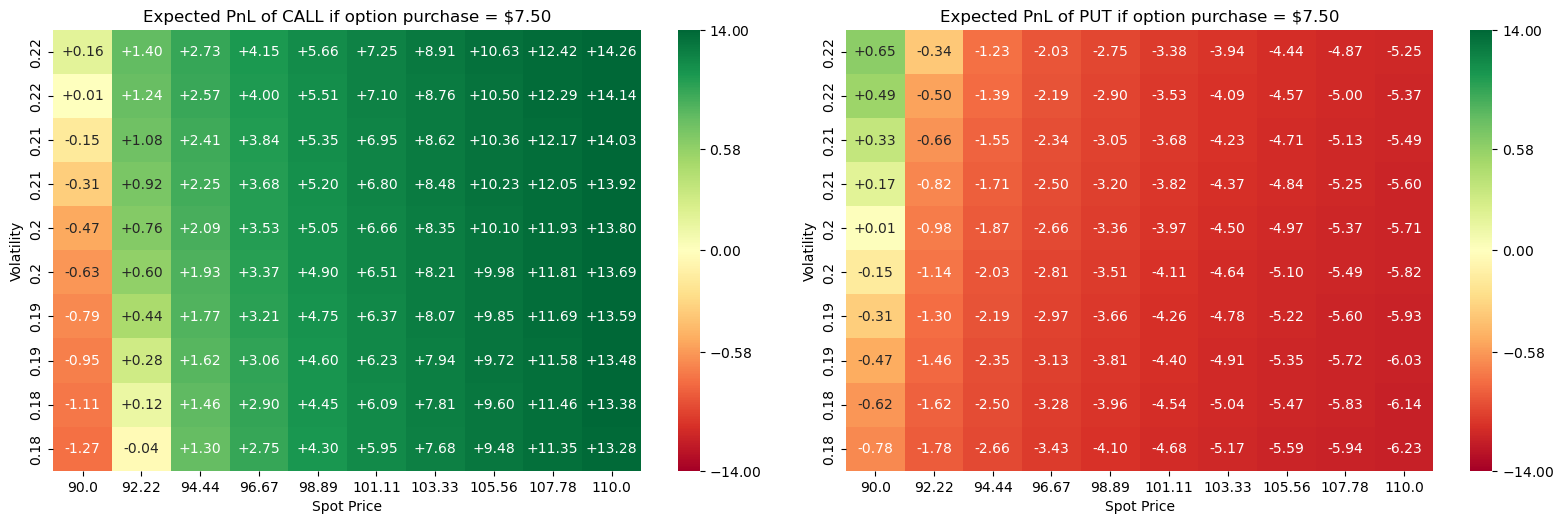

In [4]:
from matplotlib.colors import SymLogNorm, Normalize
import matplotlib.ticker as tkr
from math import ceil, floor
import seaborn as sns

buy = 7.50
calls, puts = price_heatmap(buy)

vmin = min(calls.min(), puts.min())
vmax = max(calls.max(), puts.max())
v = floor(max(abs(vmin), abs(vmax)))
copysign = lambda x,y : x if y>0 else -x
vmin, vmax = copysign(v,vmin), copysign(v,vmax)

fig, (ax_call, ax_put) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout()


log_norm = SymLogNorm(0.50, vmin=vmin, vmax=vmax)
ticks = np.concatenate((-np.logspace(np.log10(v), np.log10(0.001), 4)[:-2],[0], np.logspace(np.log10(0.001), np.log10(v), 4)[2:]))
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

vols = np.linspace(sigma*0.9, sigma*1.1, 10)
spots = np.linspace(S0*0.9, S0*1.1, 10)

for title, values, ax in [('CALL', calls, ax_call), ('PUT', puts, ax_put)]:
    sns.heatmap(values, cmap="RdYlGn", ax=ax, xticklabels=np.round(spots, 2), yticklabels=np.round(vols, 2), fmt="+.2f", annot=True, center=0, vmin=vmin, vmax=vmax, norm=log_norm, cbar_kws={"ticks": ticks, "format": formatter})
    ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
    ax.set_title(f'Expected PnL of {title} if option purchase = ${buy:.2f}')
    ax.set_xlabel('Spot Price')
    ax.set_ylabel('Volatility')
    ax.invert_yaxis()
plt.show()